<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week01/Naive_Bayes_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes and SMS Spam Collection Dataset

In this week we will use Naive Bayes (the assumption of feature independence in a probabilistic context) in order to accomplish a classification task of distinguishing spam from non-spam messages.

We will use the kaggle SMS Spam Collection dataset for this purpose: https://www.kaggle.com/uciml/sms-spam-collection-dataset

First, let us import the packages that we will need. Notice that we are importing nltk - which is a Natural Language Toolkit which will aid us in preprocessing the dataset.

In [ ]:
# please restart the runtime after running this cell (to use the versioned matplotlib)
!pip install matplotlib==3.1.0

     |████████████████████████████████| 13.1MB 279kB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import string

from sklearn.metrics import confusion_matrix

import nltk
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install wget
import wget

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=9ff4aeb01b62ddd78f64be5c64352858d9467f13cd0fc178150443535121c46a
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# download the data
url = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"
data = wget.download(url)

We will convert the data into the pandas dataframe and remove the columns we do not need. We will add an additional column with labels, converted to integers (instead of strings 'spam' and 'ham').

In [ ]:
df = pd.read_csv('./spam.csv', encoding = 'latin-1')
# delete columns with unuseful values
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df.columns = ['label', 'text']

# convert string labels to integers
df["label_int"] = df["label"].astype('category').cat.codes
df.head(n=10)

,label,text,label_int
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


As a preprocessing step, we have to clean the dataset. This is because not all sms-symbols are relevant for spam classification. For example, punctuation is not. Consider also that word endings, e.g. singular or plural, might hinder to recognize the word as the same (and update the count accordingly).

In [ ]:
# the cleanText function is from 
# https://www.kaggle.com/ishansoni/sms-spam-collection-dataset

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    # remove the punctuation from the messages
    message = message.translate(str.maketrans('', '', string.punctuation))
    # convert words in the message into their stems and remove stopwords
    words = [stemmer.stem(word) for word in message.split() 
            if word.lower() not in stopwords.words("english") and not(word.isdigit())]
    
    return " ".join(words)

df["text"] = df["text"].apply(cleanText)
df.head(n = 10)    

,label,text,label_int
0,ham,go jurong point crazi avail bugi n great world...,0
1,ham,ok lar joke wif u oni,0
2,spam,free entri wkli comp win fa cup final tkts 21s...,1
3,ham,u dun say earli hor u c alreadi say,0
4,ham,nah dont think goe usf live around though,0
5,spam,freemsg hey darl week word back id like fun st...,1
6,ham,even brother like speak treat like aid patent,0
7,ham,per request mell mell oru minnaminungint nurun...,0
8,spam,winner valu network custom select receivea å£9...,1
9,spam,mobil month u r entitl updat latest colour mob...,1


Split the data into train and test.

In [ ]:
x = df["text"]
y = df["label_int"]

perm = np.random.permutation(len(x))

split = 0.8

x_train, x_test = x[perm[:int(split*len(x))]], x[perm[int(split*len(x)):]]
y_train, y_test = y[perm[:int(split*len(y))]], y[perm[int(split*len(y)):]]

Gather all spam words in a list and all ham words in another list. 

Hint: a message consists of words. Join the messages into a global string and then split them.

In [ ]:
# 0 - ham, 1 - spam
# select all spam messages and concatenate them and split single words
spam_messages = x_train[y_train.astype('bool')].to_numpy()
spam_words = ''.join(spam_messages).split(' ')
print(spam_words)

# repeat for ham messages
ham_messages = x_train[(1-y_train).astype('bool')].to_numpy()
ham_words = ''.join(ham_messages).split(' ')
print(ham_words)

['kick', 'new', 'season', '2wks', 'free', 'goal', 'news', 'ur', 'mobil', 'txt', 'ur', 'club', 'name', 'eg', 'villasomeon', 'u', 'know', 'ask', 'date', 'servic', 'contact', 'cant', 'guess', 'call', 'reveal', 'pobox', 'ls15hb', '150pu', 'secret', 'admir', 'look', 'make', 'contact', 'ufind', 'rreveal', 'think', 'ur', 'specialcaltwink', 'bear', 'scalli', 'skin', 'jock', 'call', 'dont', 'miss', 'weekend', 'fun', 'call', '10pmin', 'stop', 'text', 'call', '08712460324nat', 'ratepleas', 'call', 'custom', 'servic', 'repres', '10am9pm', 'guarante', 'å£1000', 'cash', 'å£5000', 'prizetri', 'call', 'repli', 'sms', 'video', 'mobil', 'min', 'unlimit', 'text', 'free', 'camcord', 'repli', 'call', 'del', 'thuru', 'r', 'subscrib', 'textcomp', 'wkli', 'comp', '1st', 'wks', 'free', 'question', 'follow', 'subsequ', 'wks', 'charged150pmsg2', 'unsubscrib', 'txt', 'stop', '84128custcarwant', 'get', 'laid', 'tonight', 'want', 'real', 'dog', 'locat', 'sent', 'direct', 'ur', 'mob', 'join', 'uk', 'largest', 'dog',

In [ ]:
# calculate the prior of a message being spam or non-spam

ham_prob = len(ham_messages)/float(len(x_train))
spam_prob = len(spam_messages)/float(len(x_train))

print('probability of a message being ham: ',ham_prob)
print('probability of a message being spam: ',spam_prob)

probability of a message being ham:  0.8662777653129908
probability of a message being spam:  0.1337222346870092


Calculate the frequencies (counts) for all words given a category (spam or ham) and also one of the normalizing factors (number of word occurences in the category, meaning the sum of the frequencies of all words in a category).

In [ ]:
def get_word_counts_for_class(words):
    word_df = pd.DataFrame({'words':words})

    word_counts = word_df['words'].value_counts()

    # add up all word counts
    words_num = word_counts.to_numpy().sum()
    print('number of words: '+str(word_counts.count()))
    print('number of word occurences: ' + str(words_num)+ '\n')

    # for better interpretability rename columns
    word_counts = word_counts.reset_index()
    word_counts.columns = ['words','counts']

    print('words with the heighest count:')
    print(word_counts[:10])
    print('>----------------------<')

    # return the counts (frequencies) of words, as well as the sum of all frequencies
    return word_counts, float(words_num)

In [ ]:
# calculate the frequency of words in the spam and non-spam categories
# use the function implemented above

# Attention: we already name the variable probs, 
# but the normalization of counts is yet to be done
spam_word_probs, spam_count_sum = get_word_counts_for_class(spam_words)
ham_word_probs, ham_count_sum = get_word_counts_for_class(ham_words)

# concatenate the spam and non-spam words
# and calculate the number of words in the vocabulary
spam_words_selected = spam_word_probs['words'].to_numpy()
ham_words_selected = ham_word_probs['words'].to_numpy()
vocabulary = set(np.concatenate((spam_words_selected,ham_words_selected)))
num_words_voc = len(vocabulary)

print('number of words in the vocabulary')
print(num_words_voc)

number of words: 2285
number of word occurences: 8151

words with the heighest count:
   words  counts
0   call     245
1   free     124
2    txt     118
3   text     109
4  mobil     105
5     ur     101
6      u     100
7  claim      93
8  repli      83
9   stop      74
>----------------------<
number of words: 8302
number of word occurences: 27286

words with the heighest count:
  words  counts
0     u     648
1    go     281
2   get     250
3    im     247
4  come     189
5    ur     188
6  call     177
7  ltgt     171
8   ill     163
9  like     156
>----------------------<
number of words in the vocabulary
9881


In [ ]:
# calculate word probabilities for categories spam and non-spam:
# Laplace smoothing for naive Bayes (normalize the counts)
spam_word_probs['probs'] = (spam_word_probs['counts']+1.)/(spam_count_sum+num_words_voc)
print(spam_word_probs.head())

ham_word_probs['probs'] = (ham_word_probs['counts']+1.)/(ham_count_sum+num_words_voc)
print(ham_word_probs.head())

   words  counts     probs
0   call     245  0.013642
1   free     124  0.006932
2    txt     118  0.006599
3   text     109  0.006100
4  mobil     105  0.005878
  words  counts     probs
0     u     648  0.017462
1    go     281  0.007587
2   get     250  0.006753
3    im     247  0.006673
4  come     189  0.005112


In [ ]:
# write a function to get a log-probability of a chosen word belonging to the category
def get_logprob(word, frame, word_count, voc_size, otherframe):

    # if the word was encountered in the category:
    row =  frame.loc[frame['words'] == word]
    if not(row.empty):
        return np.log(row['probs'].to_numpy()[0])
    
    # if the word was not encountered (count=0) in a category, 
    # but is part of the vocabulary
    row = otherframe.loc[otherframe['words'] == word]
    if not(row.empty):
        return np.log(1./(word_count+voc_size))

    return 0

# test for the word 'call' the probability of a message being spam or not
print(get_logprob('call',spam_word_probs, spam_count_sum, num_words_voc, ham_word_probs))
print(get_logprob('call',ham_word_probs, ham_count_sum, num_words_voc, spam_word_probs))

-4.294571700347195
-5.341392999491763


In [ ]:
# test message for spam using Naive Bayes approach
def predict_message_labels(message):
    # calculate the probability of a message being spam
    words = message.split(' ')

    spam_word_logprobs_m = list(map(lambda x: 
                                    get_logprob(x,spam_word_probs, 
                                                spam_count_sum, num_words_voc, 
                                                ham_word_probs),words))
    spam_logprob_m = np.sum(spam_word_logprobs_m)+np.log(spam_prob)
    
    # calculate the probability of a message being ham
    ham_word_logprobs_m = list(map(lambda x: 
                                   get_logprob(x,ham_word_probs,
                                               ham_count_sum, num_words_voc, 
                                               spam_word_probs),words))
    ham_logprob_m = np.sum(ham_word_logprobs_m)+np.log(ham_prob)
   
    # decide
    if spam_logprob_m > ham_logprob_m:
        return 1
    else:
        return 0

In [ ]:
# pick a random text example, print the text and label and check the prediction

example = df['text'][22]
print(example)
print('true label: ',df['label_int'][22])
print('predicted label: ',predict_message_labels(example))

ì pay first lar da stock comin
true label:  0
predicted label:  0


In [ ]:
# apply the prediction method to all messages in the x_train and check the accuracy
train_preds = x_train.apply(predict_message_labels)
print('accuracy for the trainset:')
((train_preds==y_train).sum())/len(y_train)

accuracy for the trainset:


0.9890060578864707

Visualize your results: check how many messages have been classified correctly, or misclassified.

In [ ]:
def visualize_confusion_matrix(true_vals, pred_vals):
    cm = confusion_matrix(true_vals, pred_vals)
    index = ['predicted ham', 'predicted spam']  
    columns = ['ham', 'spam']  
    cm_df = pd.DataFrame(cm,columns,index)                      
    fig, ax = plt.subplots(figsize=(10,6))  
    sns.heatmap(cm_df,annot=True,cmap='Blues', fmt='g')

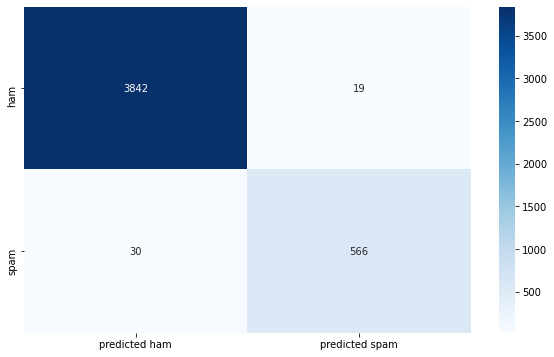

In [ ]:
visualize_confusion_matrix(y_train, train_preds)

Do the same for your test set on which you have not trained to actually validate the results.

accuracy for the testset:  0.9838565022421525


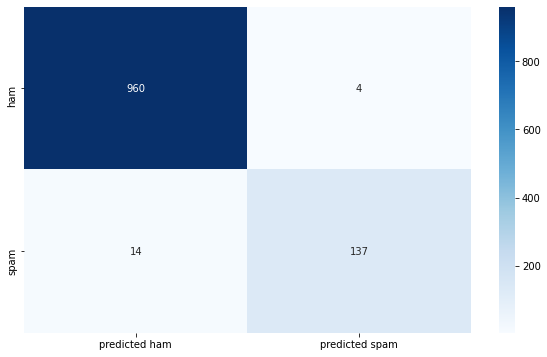

In [ ]:
test_preds = x_test.apply(predict_message_labels)
test_acc = ((test_preds==y_test).sum())/len(y_test)
print('accuracy for the testset: ',test_acc)

visualize_confusion_matrix(y_test, test_preds)